In [31]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Predict chances of grad school admission based on application data

### 1a. Define and normalize features related to predicting chance of admission.

In [5]:
admit_predict = pd.read_csv('data/Admission_Predict_Ver1.1.csv')

admit_predict.set_index('Serial No.', inplace= True)
admit_predict.head()

# LOR = letter of rec
# SOP = statement of purpose

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


Features related to chance of admission are GRE score, TOEFL score, univesity rating, SOP. LOR, GCPA and Research.

In [7]:
rankings = admit_predict['Chance of Admit'].values

features = admit_predict.drop(columns='Chance of Admit').values
scaler = StandardScaler()
features_norm = scaler.fit_transform(features)

### 1b.
Code for a simple perceptron. Initialize your weights and biases between 0 and 0.05 using your random number generator. Use the mean squares error (MSE) to adjust your weights through back-propagation.

In [11]:
class SimplePerceptron():
    def __init__(self,input_dim,output_dim,learning_rate=0.01,activation=lambda x:x,activation_grad=lambda x:1):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.activation_grad = activation_grad
        self.lr = learning_rate
        ### initialize parameters ###
        self.weights = np.random.uniform(0, 1, (self.input_dim, self.output_dim))
        self.biases = np.random.uniform(0, 0.05, self.output_dim)

    def predict(self,X):
        if len(X.shape) == 1:
            X = X.reshape((-1,1))
        dim = X.shape[1]
        # Check that the dimension of input data is as expected
        if not dim == self.input_dim:
            raise Exception("Expected input size %d, accepted %d!"%(self.input_dim,dim))
        ### Calculate logit and activation ###
        self.z = (X @ self.weights) + self.biases
        self.a = self.activation(self.z)
        return self.a
    
    def fit(self,X,y):
        # Transform the single-sample data into 2-dimensional for the convenience of matrix multiplication
        if len(X.shape) == 1:
            X = X.reshape((-1,1))
        if len(y.shape) == 1:
            y = y.reshape((-1,1))
        self.predict(X)
        # subtracts true y values from predicted values (self.a)
        errors = (self.a - y) * self.activation_grad(self.z)
        # matrix multiplication between transpose of errors and input data X
        weights_grad = errors.T.dot(X)
        # sums up errors along rows (axis 0)
        bias_grad = np.sum(errors,axis = 0)
        ### Update weights and biases from the gradient ###
        self.weights -= self.lr * weights_grad.T
        self.biases -= self.lr * bias_grad.T

        
    def train_on_epoch(self,X,y,batch_size=32):
        order = list(range(X.shape[0]))
        random.shuffle(order)
        n = 0
        while n < math.ceil(len(order)/batch_size)-1: # Parts that can fill one batch
            self.fit(X[order[n*batch_size:(n+1)*batch_size]], y[order[n*batch_size:(n+1)*batch_size]])
            n += 1
        # Parts that cannot fill one batch
        self.fit(X[order[n * batch_size:]], y[order[n * batch_size:]])
        
    def evaluate(self,X,y):
        if len(X.shape) == 1:
            X = X.reshape((1,-1))
        if len(y.shape) == 1:
            y = y.reshape((1,-1))
        ### means square error ###
        return np.mean((self.predict(X) - y) **2)
    
    def get_weights(self):
        return (self.weights,self.biases)
    
    def set_weights(self,weights):
        self.weights = np.array(weights[0])
        self.biases = np.array(weights[1])

### 1c.
Code for k-fold validation. Use 80% of the data for training, 20% of the data for testing and do 5-fold validation. Use a learning rate of 0.0001. Are the features good indicators for getting into graduate school? Now remove the GRE scores and do the same test; are GRE scores important?

In [15]:
def Kfold(k, Xs, ys, epochs, learning_rate = 0.0001, draw_curve= True):
    total_num = len(Xs)
    
    kf = KFold(n_splits = k, shuffle=True)
    train_error_all = []
    test_error_all = []
    
    for train_selector,test_selector in kf.split(range(total_num)):
        train_Xs = Xs[train_selector]
        test_Xs = Xs[test_selector]
        train_ys = ys[train_selector]
        test_ys = ys[test_selector]
        
        val_array = []
        train_in, val_in, train_real, val_real = train_test_split(train_Xs,train_ys)
        
        model = SimplePerceptron(train_Xs.shape[1], 1)
        
        # save lowest weights, so that we can recover the best model
        weights = model.get_weights()
        lowest_val_err = np.inf
        for _ in range(epochs):
            model.train_on_epoch(train_in,train_real)
            val_err = model.evaluate(val_in,val_real)
            val_array.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights = model.get_weights()
   
        final_epochs = val_array.index(min(val_array)) + 1
        print("Number of epochs with lowest validation:",final_epochs)
        model.set_weights(weights)


        train_error = model.evaluate(train_Xs, train_ys)
        train_error_all.append(train_error)
        test_error = model.evaluate(test_Xs, test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))

    def show_correlation(xs,ys):
        xs = model.predict(xs).reshape(-1,)
        ys = ys.reshape(-1)
        plt.figure()
        plt.scatter(xs,ys,s=0.5)
        r = [np.min([np.min(xs),np.min(ys)]),np.max([np.max(xs),np.max(ys)])]
        plt.plot(r,r,'r')
        plt.xlabel("Predictions")
        plt.ylabel("Ground truth")
        corr=np.corrcoef([xs,ys])[1,0]
        print("Correlation coefficient:",corr)
        
    # return the last model
    return model


Number of epochs with lowest validation: 25
Train error: 0.03841450349003757
Test error: 0.038764645636031686
Number of epochs with lowest validation: 33
Train error: 0.03346767753726384
Test error: 0.03718447872389862
Number of epochs with lowest validation: 20
Train error: 0.03840745727714973
Test error: 0.04255038033025405
Number of epochs with lowest validation: 27
Train error: 0.037180144085812494
Test error: 0.03558700152695735
Number of epochs with lowest validation: 48
Train error: 0.035995867167260893
Test error: 0.029353812594197785
Final results:
Training error:0.036693+-0.001845
Testing error:0.036688+-0.004334


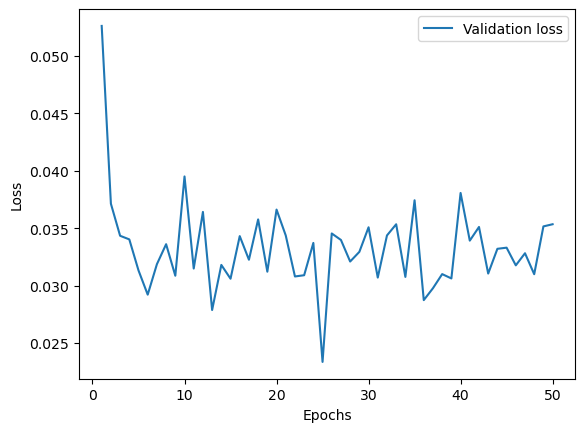

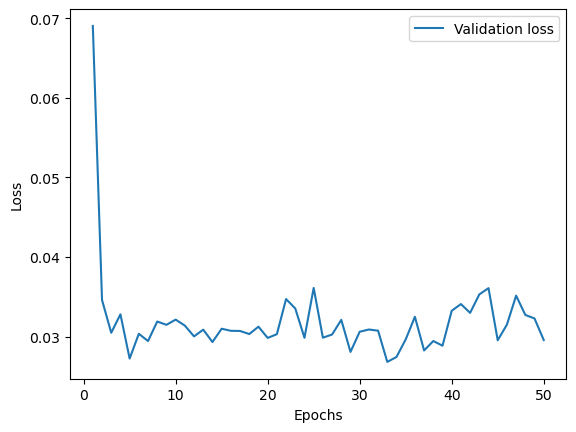

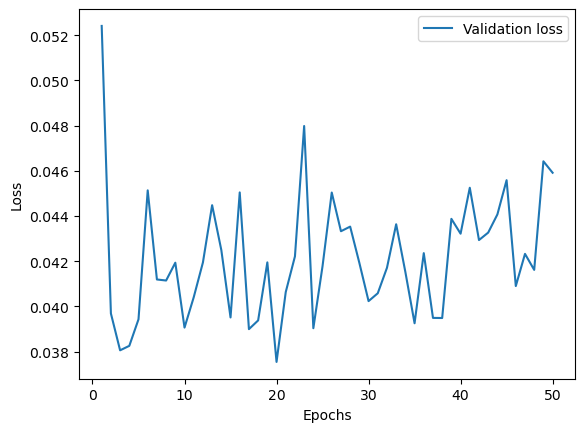

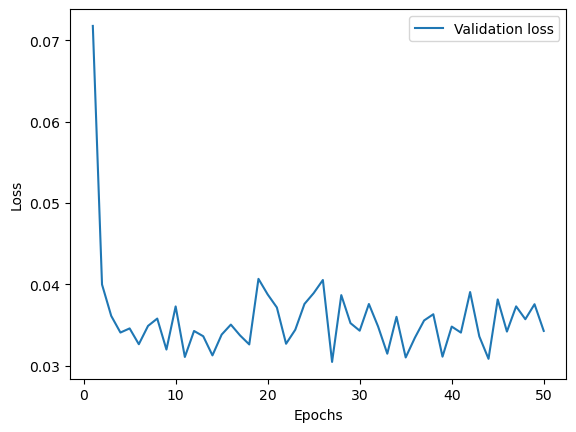

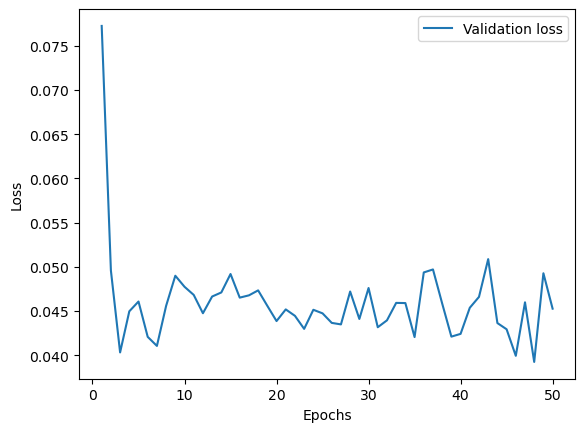

In [17]:
def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1-np.tanh(x)**2

model = Kfold(5, features_norm, rankings, 50, learning_rate = 0.00001, draw_curve = True)
print(model)

In [18]:
def show_correlation(xs,ys):
    plt.figure()
    plt.scatter(xs,ys,s=0.5)
    r = [np.min([np.min(xs),np.min(ys)]),np.max([np.max(xs),np.max(ys)])]
    plt.plot(r,r,'r')
    plt.xlabel("Predictions")
    plt.ylabel("Ground truth")
    corr=np.corrcoef([xs,ys])[1,0]
    print("Correlation coefficient:",corr)

Correlation coefficient: 0.9057438961067454


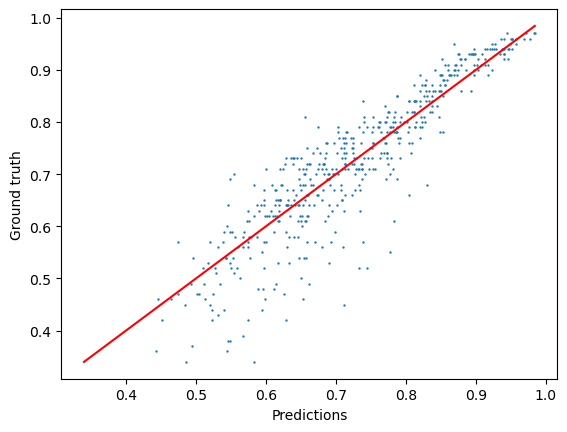

In [47]:
show_correlation(features_norm, rankings)

Yes, I think the features are a good indicator of getting into graduate school. Now we remove GRE Scores and test again.

Number of epochs with lowest validation: 40
Train error: 0.03777334970105135
Test error: 0.039393551638148054
Number of epochs with lowest validation: 48
Train error: 0.03940137817995659
Test error: 0.04197939255492461
Number of epochs with lowest validation: 40
Train error: 0.0406691108044897
Test error: 0.041144278211355405
Number of epochs with lowest validation: 31
Train error: 0.032499614554096806
Test error: 0.03606012726221478
Number of epochs with lowest validation: 27
Train error: 0.03781052166665922
Test error: 0.028571107476685887
Final results:
Training error:0.037631+-0.002784
Testing error:0.037430+-0.004872


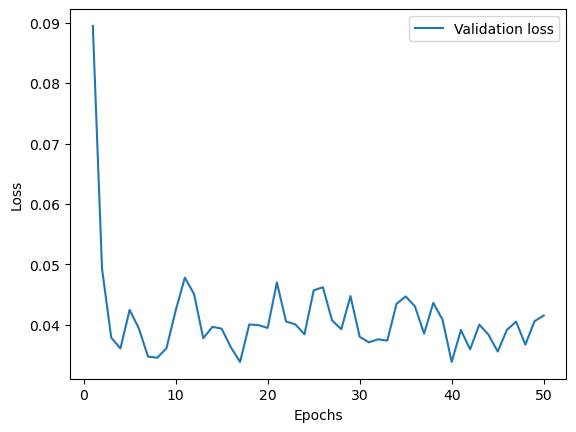

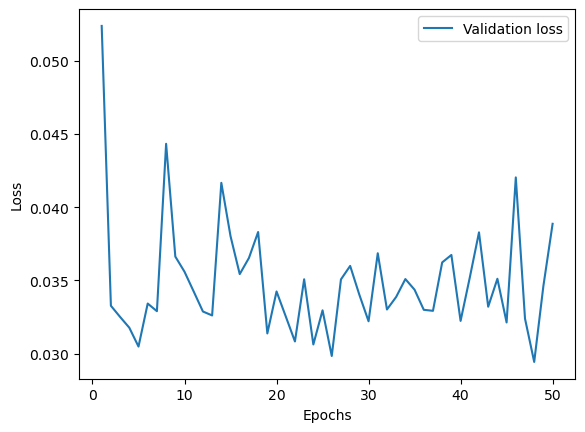

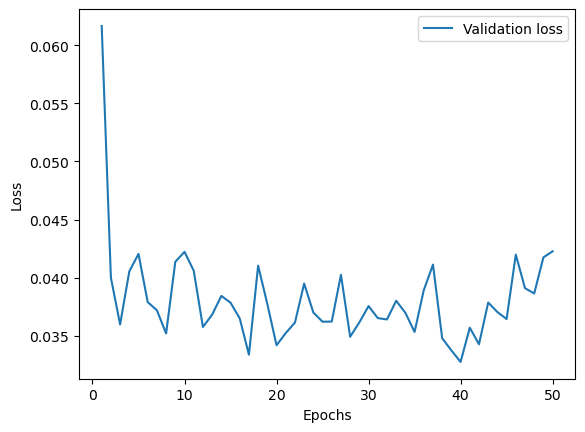

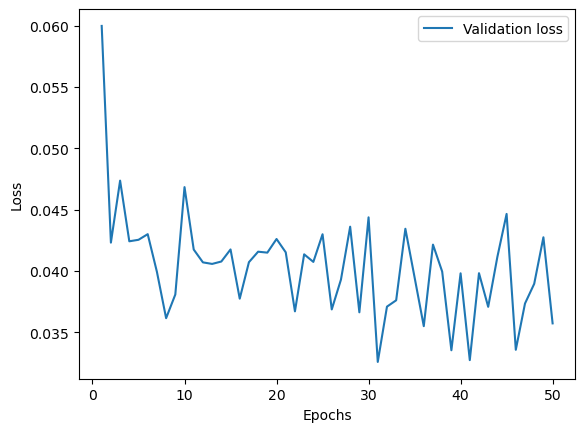

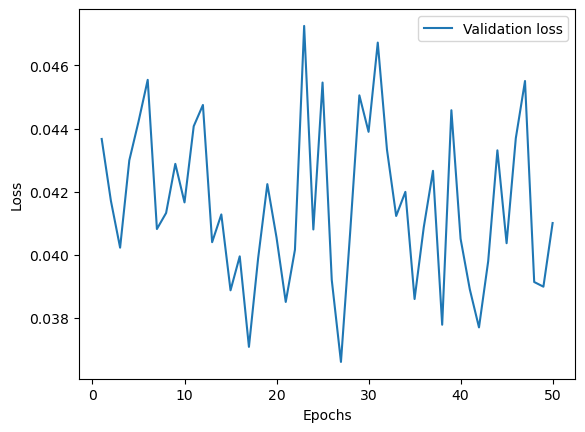

In [20]:
features_no_GRE = admit_predict.drop(columns=['Chance of Admit', 'GRE Score']).values
scaler = StandardScaler()
features_norm_no_GRE = scaler.fit_transform(features)

model2 = Kfold(5, features_norm_no_GRE, rankings, 50, learning_rate = 0.00001, draw_curve = True)
print(model2)

Correlation coefficient: 0.9057438961067454


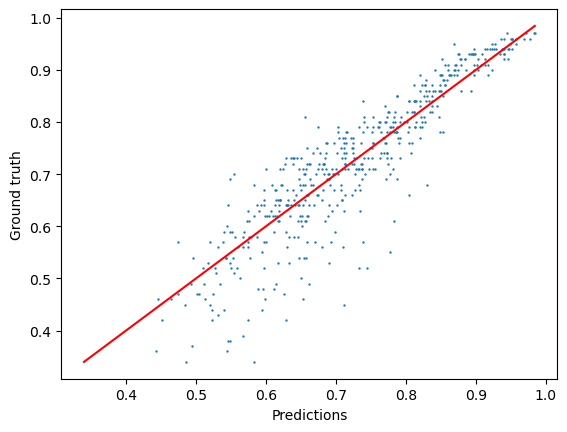

In [51]:
show_correlation(features_norm_no_GRE, rankings)

I guess GRE Scores are not that important; the correlation graphs look more or less identical.

### 2a

In [22]:
titanic = pd.read_csv('data/titantic.csv')
titanic.set_index('PassengerId', inplace= True)
titanic = titanic.dropna()
titanic_numericals = titanic.drop(['Ticket', 'Name', 'Sex'], axis= 1)

In [27]:
normalized_numerical = titanic_numericals.iloc[:, 1:6].apply(lambda x: (x - x.mean()) / x.std())

encoder = OneHotEncoder(handle_unknown='ignore')
encoded_categoricals = encoder.fit_transform(titanic[['Sex', 'Embarked']]).toarray()
encoded_categoricals_df = pd.DataFrame(encoded_categoricals)

titanic_transformed = pd.concat([normalized_numerical, encoded_categoricals_df], axis=1)
titanic_transformed = titanic_transformed.dropna()

titanic_transformed.head()

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4
2,-0.371238,0.148657,0.831347,-0.630001,-0.096914,0.0,1.0,0.0,0.0,1.0
4,-0.371238,-0.043111,0.831347,-0.630001,-0.335078,1.0,0.0,0.0,0.0,1.0
7,-0.371238,1.171422,-0.721066,-0.630001,-0.351287,0.0,1.0,0.0,0.0,1.0
11,3.510848,-2.024719,0.831347,0.695174,-0.811843,1.0,0.0,0.0,0.0,1.0
12,-0.371238,1.427114,-0.721066,-0.630001,-0.682828,0.0,1.0,0.0,0.0,1.0


### 2b
Use the simple perceptron model we developed in Q1. Use 80% of the data for training and 20%
of  the data  for  testing  and  do  5-fold  validation.  Can  we  predict who  will survive?  Play  around  with  the 
features to determine which ones give you a better chance to get back to shore

Number of epochs with lowest validation: 10
Train error: 0.43359753790668354
Test error: 0.44380937517139435
Number of epochs with lowest validation: 60
Train error: 0.35347353399476644
Test error: 0.36740465976725495
Number of epochs with lowest validation: 9
Train error: 0.3745148180191569
Test error: 0.461684963206788
Number of epochs with lowest validation: 27
Train error: 0.32873220476691684
Test error: 0.4834515350289165
Number of epochs with lowest validation: 30
Train error: 0.32029200851390854
Test error: 0.45040893667831255
Final results:
Training error:0.362122+-0.040501
Testing error:0.441352+-0.039350


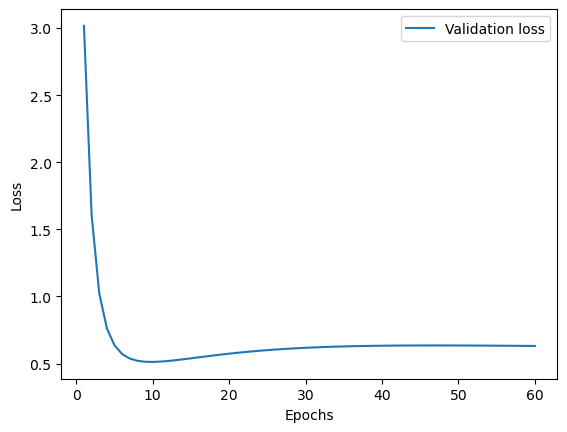

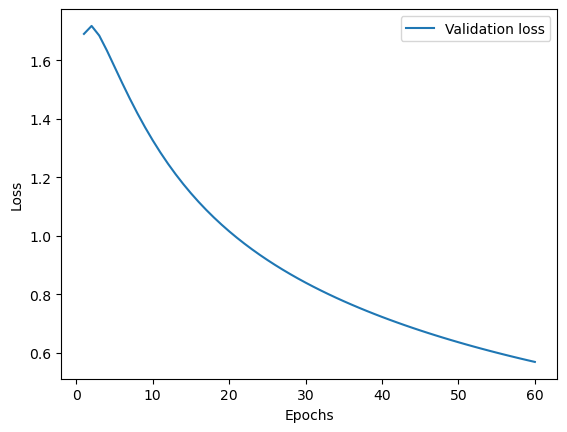

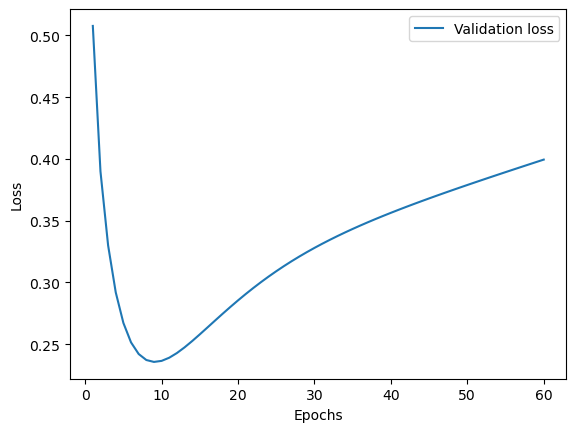

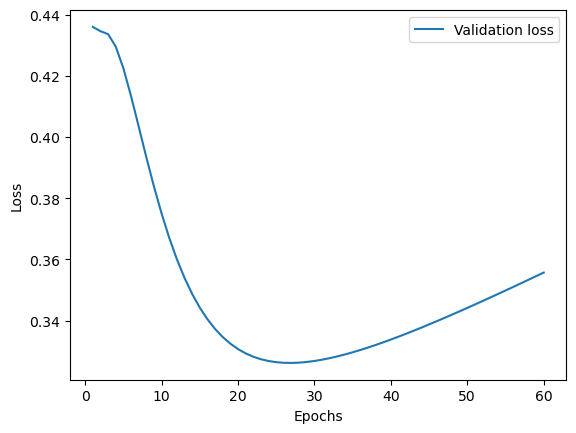

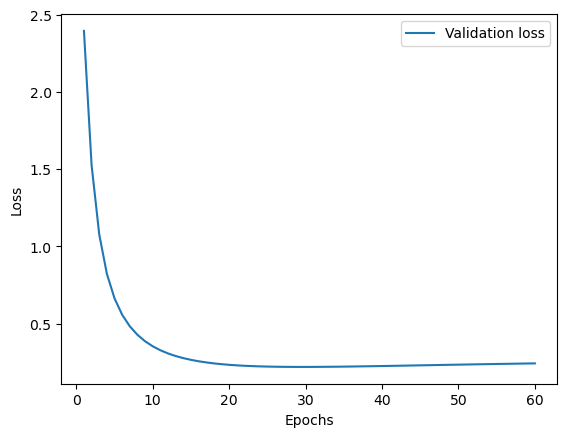

In [28]:
features = titanic_transformed.values
predictions = titanic['Survived'].values

model = Kfold(5, features, predictions, 60)

In [29]:
weights = model.get_weights()
weights

(array([[ 0.05507978],
        [-0.1989856 ],
        [ 0.04624116],
        [-0.05117091],
        [ 0.05717881],
        [ 0.55642789],
        [ 0.5536097 ],
        [ 0.49479225],
        [ 0.39414229],
        [ 0.66755069]]),
 array([-0.55435374]))

Yes, we can fairly accurately predict who will survive. The largest determinant for survival was Sex, as it had the largest weight.

## 3
Let’s try to fit to a simple sine function y = 3 sin(x) + 5 with the simple perceptron and a simple fully connected network.

### 3a
Use the generate_data() function provided in the reference file to generate the training data (5000
points). Do 5-fold cross validation with the simple perceptron model. How well is the prediction? Generate
1000 new points as your test data, and use the show_correlation() function to see how well your model
agree with the test data


In [32]:
def generate_X(number):
    xs = (np.random.random(number)*2-1) * 10
    return xs
    
def generate_data(number,stochascity=0.05):
    xs = generate_X(number)
    fs = 3 * np.sin(xs)-5
    stochastic_ratio = (np.random.random(number)*2-1) * stochascity+1
    return xs,fs * stochastic_ratio

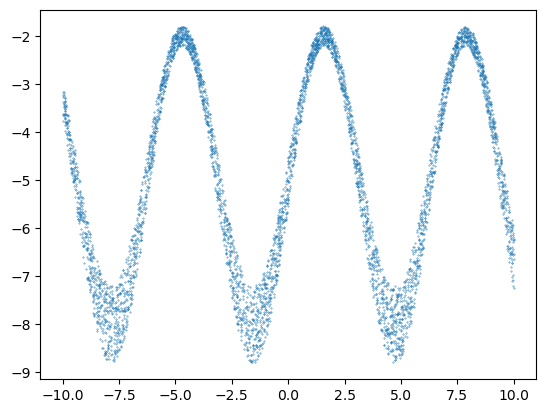

In [33]:
x, y = generate_data(5000, 0.1)
plt.scatter(x, y, s=0.1)

In [34]:
x, y = generate_data = (1000, 0.1)

### 3b

Fold 1: MSE = 6.557191509323998
Fold 2: MSE = 5.759326237994227
Fold 3: MSE = 6.967023793409838
Fold 4: MSE = 6.604969312598687
Fold 5: MSE = 6.710412821254925


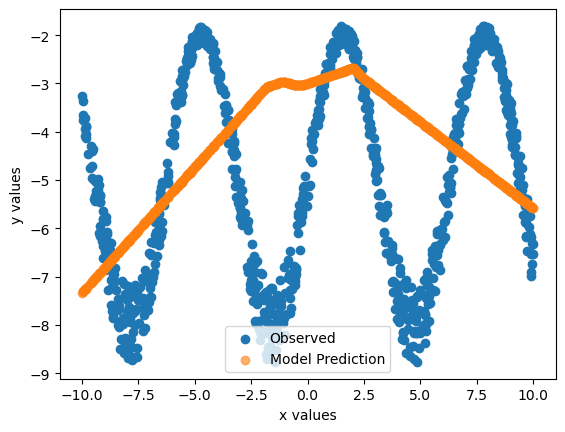

In [66]:
x, y = generate_data(1000, 0.1)

MLP = MLPRegressor(hidden_layer_sizes=(8,), random_state = 49)

mean_squared_error = -cross_val_score(MLP, x.reshape(-1, 1), y, cv = 5, scoring='neg_mean_squared_error')

for fold, mse in enumerate(mean_squared_error):
    print(f'Fold {fold + 1}: MSE = {mse}')

MLP.fit(x.reshape(-1, 1), y)
y_pred = MLP.predict(x.reshape(-1, 1))

plt.figure()
plt.scatter(x, y, label='Observed')
plt.scatter(x, y_pred, label='Model Prediction', alpha=0.6)
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()
plt.show()

### 3c
The model prediction is not good at all. Let's add more hidden layers to see if that improved our predictions.

Fold 1: MSE = 3.0936014218491175
Fold 2: MSE = 2.6880131156572475
Fold 3: MSE = 3.0773700882193693
Fold 4: MSE = 3.228400144248916
Fold 5: MSE = 2.4915781161043653


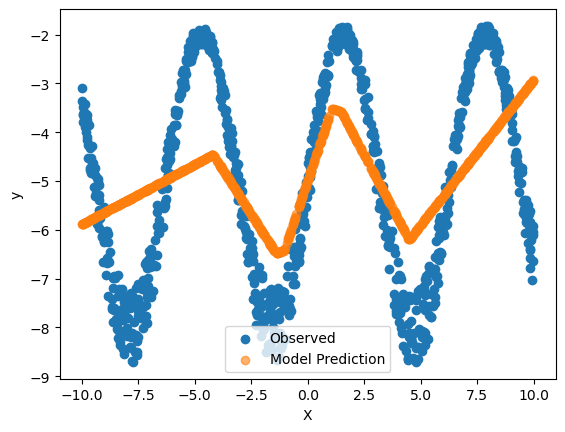

In [67]:
# second try with more hidden layers


x, y = generate_data(1000, 0.1)

MLP = MLPRegressor(hidden_layer_sizes=(1000,), random_state = 49)

mean_squared_error = -cross_val_score(MLP, x.reshape(-1, 1), y, cv = 5, scoring='neg_mean_squared_error')

for fold, mse in enumerate(mean_squared_error):
    print(f'Fold {fold + 1}: MSE = {mse}')

MLP.fit(x.reshape(-1, 1), y)
y_pred = MLP.predict(x.reshape(-1, 1))

plt.figure()
plt.scatter(x, y, label='Observed')
plt.scatter(x, y_pred, label='Model Prediction', alpha=0.6)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

I increased the number of hidden layers to 1000 and this greatly improved the model. However, it's still not a good fit to the data despite having very many hidden layers (1000). In real life, I don't know if this is even a realistic number of hidden layers to have in a model.